# Классификация данных на плоскости с одним скрытым слоем

Добро пожаловать на задание по программированию. Пришло время построить свою первую нейронную сеть, у которой будет скрытый слой. Вы увидите большую разницу между этой моделью и той, которую вы реализовали с помощью логистической регрессии.

**Вы узнаете, как:**
- Реализуйте двухклассовую классификационную нейронную сеть с одним скрытым слоем.
- Используйте устройства с нелинейной функцией активации, например tanh
- Вычислить потерю перекрестной энтропии
- Реализация прямого и обратного распространения

## 1 - Пакеты ##

Давайте сначала импортируем все пакеты, которые вам понадобятся во время этого задания.
- [numpy](www.numpy.org) — фундаментальный пакет для научных вычислений на Python.
- [sklearn](http://scikit-learn.org/stable/) предоставляет простые и эффективные инструменты для интеллектуального анализа данных.
- [matplotlib](http://matplotlib.org) — библиотека для построения графиков на Python.
- testCases предоставляет несколько тестовых примеров для оценки правильности ваших функций.
- planar_utils предоставляет различные полезные функции, используемые в этом задании.


In [62]:
# Package imports
import numpy as np
import matplotlib.pyplot as plt
from testCases_v2 import *
import sklearn
import sklearn.datasets
import sklearn.linear_model
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets

%matplotlib inline

np.random.seed(1) # set a seed so that the results are consistent

## 2 - Набор данных ##

Во-первых, давайте получим набор данных, с которым вы будете работать. Следующий код загрузит набор данных двух классов «цветок» в переменные `X` и `Y`.

In [63]:
X, Y = load_planar_dataset()

Визуализируем набор данных с помощью matplotlib. Данные выглядят как «цветок» с красными (метка y=0) и синими (y=1) точками. Ваша цель — построить модель, соответствующую этим данным.

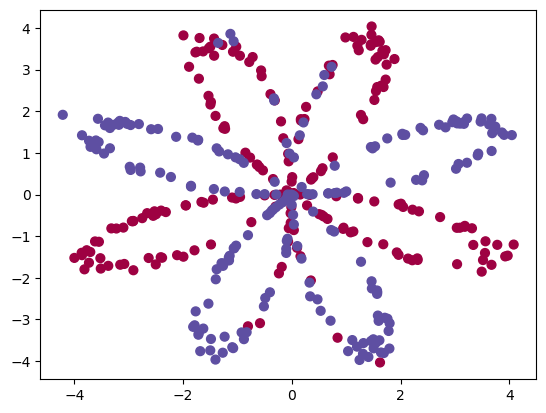

In [64]:
# Visualize the data:
plt.scatter(X[0, :], X[1, :], c=Y.ravel(), s=40, cmap=plt.cm.Spectral);

У вас есть:
     - numpy-массив (матрица) X, содержащий ваши координаты (фичи) (x1, x2)
     - массив (вектор) Y, содержащий ваши метки (красный: 0, синий: 1).

Давайте сначала лучше поймем, что представляют собой наши данные.

**Упражнение**. Сколько обучающих примеров у вас есть? Какова «форма» (shape) переменных «X» и «Y»?

**Подсказка**: как получить форму numpy массива? [(справка)](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.shape.html)

In [65]:
### START CODE HERE ### (≈ 3 lines of code)

shape_X = X.shape
shape_Y = Y.shape
m = shape_X[1] # Количество строк, т.е. количество обучающих примеров
### END CODE HERE ###

print ('The shape of X is: ' + str(shape_X))
print ('The shape of Y is: ' + str(shape_Y))
print ('I have m = %d training examples!' % (m))

The shape of X is: (2, 400)
The shape of Y is: (1, 400)
I have m = 400 training examples!


**Expected Output**:
       
<table style="width:20%">
  
  <tr>
    <td>**shape of X**</td>
    <td> (2, 400) </td>
  </tr>
  
  <tr>
    <td>**shape of Y**</td>
    <td>(1, 400) </td>
  </tr>
  <tr>
    <td>**m**</td>
    <td> 400 </td>
  </tr>
  
</table>

## 3 - Простая логистическая регрессия

Прежде чем строить полную нейронную сеть, давайте сначала посмотрим, как логистическая регрессия справляется с этой задачей. Для этого вы можете использовать встроенные функции sklearn. Запустите приведенный ниже код, чтобы обучить классификатор логистической регрессии на наборе данных.

In [66]:
# Train the logistic regression classifier
clf = sklearn.linear_model.LogisticRegressionCV();
clf.fit(X.T, Y.ravel());

In [67]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Теперь вы можете построить границу решения этих моделей. Запустите код ниже.

Accuracy of logistic regression: 47 % (percentage of correctly labelled datapoints)


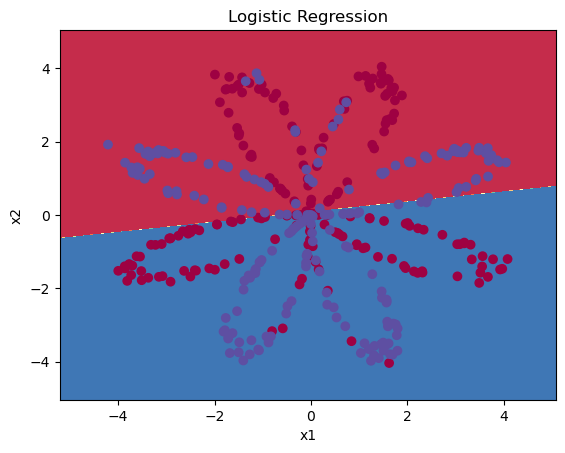

In [68]:
# Plot the decision boundary for logistic regression
plot_decision_boundary(lambda x: clf.predict(x), X, Y.ravel())
plt.title("Logistic Regression")

# Print accuracy
LR_predictions = clf.predict(X.T)
print ('Accuracy of logistic regression: %d ' % float((np.dot(Y,LR_predictions) + np.dot(1-Y,1-LR_predictions))/float(Y.size)*100) +
       '% ' + "(percentage of correctly labelled datapoints)")

**Ожидаемый результат**:

<table style="width:20%">
  <tr>
    <td>**Accuracy**</td>
    <td> 47% </td>
  </tr>
  
</table>


**Интерпретация**: набор данных не является линейно разделимым, поэтому логистическая регрессия работает неэффективно. Надеюсь, нейронная сеть справится лучше. Давайте попробуем это!

## 4 - Модель нейронной сети

Логистическая регрессия не сработала с «набором цветочных данных». Обучим нейронную сеть с одним скрытым слоем.

**Вот наша модель**:
<img src="images/classification_kiank.png" style="width:600px;height:300px;">

**Математически**:

Для одного примера $x^{(i)}$:
$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1]}\tag{1}$$
$$a^{[1] (i)} = \tanh(z^{[1] (i)})\tag{2}$$
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2]}\tag{3}$$
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{4}$$
$$y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{if } a^{[2](i)} > 0.5 \\ 0 & \mbox{otherwise } \end{cases}\tag{5}$$

Учитывая прогнозы всех примеров, вы также можете вычислить стоимость $J$ следующим образом:
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{6}$$

**Напоминание**. Общая методология построения нейронной сети заключается в следующем:
 1. Определите структуру нейронной сети (количество входных блоков, количество скрытых блоков и т. д.).
 2. Инициализируйте параметры модели.
 3. Цикл:
 - Реализация прямого распространения
 - Вычислить потери
 - Реализуйте обратное распространение, чтобы получить градиенты.
 - Обновление параметров (градиентный спуск)

Вы создаете вспомогательные функции для вычисления шагов 1-3, а затем объединяете их в одну функцию, которую мы называем nn_model(). После того, как вы построили `nn_model()` и изучили правильные параметры, вы можете делать прогнозы на основе новых данных.

### 4.1 - Определение структуры нейронной сети ####

**Упражнение**. Определите три переменные:  
 - n_x: размер входного слоя
 - n_h: размер скрытого слоя (установите значение 4)
 - n_y: размер выходного слоя

**Подсказка**: используйте размеры X и Y, чтобы найти n_x и n_y. Кроме того, жестко запрограммируйте размер скрытого слоя равным 4.

In [69]:
# GRADED FUNCTION: layer_sizes

def layer_sizes(X, Y):
    """
    Arguments:
    X -- input dataset of shape (input size, number of examples)
    Y -- labels of shape (output size, number of examples)

    Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer
    n_y -- the size of the output layer
    """
    ### START CODE HERE ### (≈ 3 lines of code)
    n_x = X.shape[0]  # количество входных признаков (input size)
    n_h = 4  # размер скрытого слоя (можно изменить)
    n_y = Y.shape[0]  # количество выходных признаков (output size)
    ### END CODE HERE ###
    return (n_x, n_h, n_y)

In [70]:
X_assess, Y_assess = layer_sizes_test_case()
(n_x, n_h, n_y) = layer_sizes(X_assess, Y_assess)
print("The size of the input layer is: n_x = " + str(n_x))
print("The size of the hidden layer is: n_h = " + str(n_h))
print("The size of the output layer is: n_y = " + str(n_y))

The size of the input layer is: n_x = 5
The size of the hidden layer is: n_h = 4
The size of the output layer is: n_y = 2


**Ожидаемый результат** (это не размеры, которые вы будете использовать для своей сети, они используются просто для оценки функции, которую вы только что закодировали).

<table style="width:20%">
  <tr>
    <td>**n_x**</td>
    <td> 5 </td>
  </tr>
  <tr>
    <td>**n_h**</td>
    <td> 4 </td>
  </tr>
  <tr>
    <td>**n_y**</td>
    <td> 2 </td>
  </tr>
  
</table>

### 4.2 - Инициализация параметров модели ####

**Упражнение**: Реализуйте функцию `initialize_parameters()`.

**Инструкции**:
- Убедитесь, что размеры ваших параметров верны. При необходимости обратитесь к рисунку нейронной сети выше.
- Вы инициализируете матрицы весов случайными значениями.
     - Используйте: `np.random.randn(a,b) * 0,01` для случайной инициализации матрицы формы (a,b).
- Вы инициализируете векторы смещения как нули.
     - Используйте: `np.zeros((a,b))` для инициализации матрицы формы (a,b) нулями.

In [71]:
# GRADED FUNCTION: initialize_parameters

def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer

    Returns:
    params -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """

    np.random.seed(2)  # фиксируем случайность для воспроизводимости

    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = np.random.randn(n_h, n_x) * 0.01  # веса для скрытого слоя
    b1 = np.zeros((n_h, 1))                # смещения для скрытого слоя
    W2 = np.random.randn(n_y, n_h) * 0.01  # веса для выходного слоя
    b2 = np.zeros((n_y, 1))                # смещения для выходного слоя
    ### END CODE HERE ###

    # Проверки на соответствие ожидаемой формы
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))

    # Сохранение параметров в словарь
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}

    return parameters

In [72]:
n_x, n_h, n_y = initialize_parameters_test_case()

parameters = initialize_parameters(n_x, n_h, n_y)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[-0.00416758 -0.00056267]
 [-0.02136196  0.01640271]
 [-0.01793436 -0.00841747]
 [ 0.00502881 -0.01245288]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.01057952 -0.00909008  0.00551454  0.02292208]]
b2 = [[0.]]


**Ожидаемый результат**:

<table style="width:90%">
  <tr>
    <td>**W1**</td>
    <td> [[-0.00416758 -0.00056267]
 [-0.02136196  0.01640271]
 [-0.01793436 -0.00841747]
 [ 0.00502881 -0.01245288]] </td>
  </tr>
  
  <tr>
    <td>**b1**</td>
    <td> [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]] </td>
  </tr>
  
  <tr>
    <td>**W2**</td>
    <td> [[-0.01057952 -0.00909008  0.00551454  0.02292208]]</td>
  </tr>
  

  <tr>
    <td>**b2**</td>
    <td> [[ 0.]] </td>
  </tr>
  
</table>



### 4.3 - Полный цикл ####

**Задача**: Реализуйте `forward_propagation()`.

**Инструкции**:
- Посмотрите выше на математическое представление вашего классификатора.
- Вы можете использовать функцию `sigmoid()`. Он встроен (импортирован) в ноутбук.
- Вы можете использовать функцию `np.tanh()`. Это часть библиотеки numpy.
- Шаги, которые вам необходимо реализовать:
     1. Получите каждый параметр из словаря "parameters" (который является результатом `initialize_parameters()`), используя `parameters[..]`.
     2. Внедрить прямое распространение. Вычислите $Z^{[1]}, A^{[1]}, Z^{[2]}$ и $A^{[2]}$ (вектор всех ваших прогнозов на всех примерах в обучении). набор).
- Значения, необходимые для обратного распространения ошибки, хранятся в «кеше». «Кэш» будет передан в качестве входных данных для функции обратного распространения ошибки.

In [73]:
# GRADED FUNCTION: forward_propagation

def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)

    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    # Извлечение параметров из словаря "parameters"
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    ### END CODE HERE ###

    # Реализация прямого распространения
    ### START CODE HERE ### (≈ 4 lines of code)
    Z1 = np.dot(W1, X) + b1                     # Вычисление Z1
    A1 = np.tanh(Z1)                            # Применение tanh к Z1
    Z2 = np.dot(W2, A1) + b2                    # Вычисление Z2
    A2 = 1 / (1 + np.exp(-Z2))                  # Применение сигмоиды к Z2
    ### END CODE HERE ###

    assert(A2.shape == (1, X.shape[1]))  # Проверка формы A2

    # Сохранение промежуточных значений в кэш
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}

    return A2, cache

In [74]:
X_assess, parameters = forward_propagation_test_case()
A2, cache = forward_propagation(X_assess, parameters)

# Note: we use the mean here just to make sure that your output matches ours.
print(np.mean(cache['Z1']) ,np.mean(cache['A1']),np.mean(cache['Z2']),np.mean(cache['A2']))

0.26281864019752443 0.09199904522700109 -1.3076660128732143 0.21287768171914198


**Ожидаемый результат**:
<table style="width:50%">
  <tr>
    <td> 0.262818640198 0.091999045227 -1.30766601287 0.212877681719 </td>
  </tr>
</table>

Теперь, когда вы вычислили $A^{[2]}$ (в переменной Python «`A2`»), которая содержит $a^{[2](i)}$ для каждого примера, вы можете вычислить функцию потерь (лосс) следующим образом:

$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large{(} \small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) \large{)} \small\tag{13}$$

**Упражнение**. Реализуйте `compute_cost()` для вычисления значения стоимости $J$.

**Инструкция**:  
Есть много способов реализовать потерю перекрестной энтропии. Чтобы помочь вам, мы рассказываем, как бы мы реализовали
$- \sum\limits_{i=0}^{m}  y^{(i)}\log(a^{[2](i)})$:
```python
logprobs = np.multiply(np.log(A2),Y)
cost = - np.sum(logprobs)                # no need to use a for loop!
```

(вы можете использовать либо `np.multiply()`, а затем `np.sum()`, либо напрямую `np.dot()`).

In [75]:
# GRADED FUNCTION: compute_cost

def compute_cost(A2, Y, parameters):
    """
    Computes the cross-entropy cost given in equation (13)

    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    parameters -- python dictionary containing your parameters W1, b1, W2 and b2

    Returns:
    cost -- cross-entropy cost given equation (13)
    """

    m = Y.shape[1]  # количество примеров

    # Вычисление кросс-энтропийной функции стоимости
    ### START CODE HERE ### (≈ 2 lines of code)
    logprobs = np.multiply(np.log(A2), Y) + np.multiply(np.log(1 - A2), (1 - Y))
    cost = -np.sum(logprobs) / m
    ### END CODE HERE ###

    cost = np.squeeze(cost)  # делает cost скаляром, если он имеет вид массива [[value]]
    assert(isinstance(cost, float))  # проверка, что cost — это float

    return cost

In [76]:
A2, Y_assess, parameters = compute_cost_test_case()

print("cost = " + str(compute_cost(A2, Y_assess, parameters)))

cost = 0.6930587610394646


**Ожидаемый результат**:
<table style="width:20%">
  <tr>
    <td>**cost**</td>
    <td> 0.693058761... </td>
  </tr>
  
</table>

Используя кеш, вычисленный во время прямого распространения, теперь можно реализовать обратное распространение.

**Вопрос**: Реализовать функцию `backward_propagation()`.

**Инструкции**:  
Обратное распространение ошибки обычно является самой сложной (наиболее математической) частью глубокого обучения. В помощь вам привожу слайд из лекции по обратному распространению ошибки. Вам понадобится использовать шесть уравнений в правой части этого слайда, поскольку вы создаете векторизованную реализацию.

<img src="images/grad_summary.png" style="width:600px;height:300px;">

<!--
$\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } = \frac{1}{m} (a^{[2](i)} - y^{(i)})$

$\frac{\partial \mathcal{J} }{ \partial W_2 } = \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } a^{[1] (i) T} $

$\frac{\partial \mathcal{J} }{ \partial b_2 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)}}}$

$\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} } =  W_2^T \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } * ( 1 - a^{[1] (i) 2}) $

$\frac{\partial \mathcal{J} }{ \partial W_1 } = \frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} }  X^T $

$\frac{\partial \mathcal{J} _i }{ \partial b_1 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)}}}$

- Обратите внимание, что $*$ обозначает поэлементное умножение.
- Обозначения, которые вы будете использовать, распространены в программировании глубокого обучения:
    - dW1 = $\frac{\partial \mathcal{J} }{ \partial W_1 }$
    - db1 = $\frac{\partial \mathcal{J} }{ \partial b_1 }$
    - dW2 = $\frac{\partial \mathcal{J} }{ \partial W_2 }$
    - db2 = $\frac{\partial \mathcal{J} }{ \partial b_2 }$
    
!-->

- Совет:  
Чтобы вычислить dZ1, вам нужно вычислить $g^{[1]'}(Z^{[1]})$. Поскольку $g^{[1]}(.)$ — функция активации `tanh`, $a = g^{[1]}(z)$, то $g^{[1]'}(z) = 1- а^2$. Таким образом, вы можете вычислить $g^{[1]'}(Z^{[1]})$ используя `(1 - np.power(A1, 2))`.

In [77]:
# GRADED FUNCTION: backward_propagation

def backward_propagation(parameters, cache, X, Y):
    """
    Implement the backward propagation using the instructions above.

    Arguments:
    parameters -- python dictionary containing our parameters
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (n_x, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)

    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[1]  # количество примеров

    # Извлечение параметров из "parameters"
    W1 = parameters["W1"]
    W2 = parameters["W2"]

    # Извлечение значений из "cache"
    A1 = cache["A1"]
    A2 = cache["A2"]

    # Обратное распространение: вычисление dW1, db1, dW2, db2
    dZ2 = A2 - Y  # dZ2 = A2 - Y
    dW2 = (1/m) * np.dot(dZ2, A1.T)  # dW2 = dZ2 * A1^T / m
    db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)  # db2 = сумма по всем примерам dZ2

    dZ1 = np.dot(W2.T, dZ2) * (1 - np.power(A1, 2))  # dZ1 = W2^T * dZ2 * (1 - A1^2)
    dW1 = (1/m) * np.dot(dZ1, X.T)  # dW1 = dZ1 * X^T / m
    db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)  # db1 = сумма по всем примерам dZ1

    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}

    return grads

In [78]:
parameters, cache, X_assess, Y_assess = backward_propagation_test_case()

grads = backward_propagation(parameters, cache, X_assess, Y_assess)
print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("db2 = "+ str(grads["db2"]))

dW1 = [[ 0.00301023 -0.00747267]
 [ 0.00257968 -0.00641288]
 [-0.00156892  0.003893  ]
 [-0.00652037  0.01618243]]
db1 = [[ 0.00176201]
 [ 0.00150995]
 [-0.00091736]
 [-0.00381422]]
dW2 = [[ 0.00078841  0.01765429 -0.00084166 -0.01022527]]
db2 = [[-0.16655712]]


**Ожидаемый результат**:



<table style="width:80%">
  <tr>
    <td>**dW1**</td>
    <td> [[ 0.00301023 -0.00747267]
 [ 0.00257968 -0.00641288]
 [-0.00156892  0.003893  ]
 [-0.00652037  0.01618243]] </td>
  </tr>
  
  <tr>
    <td>**db1**</td>
    <td>  [[ 0.00176201]
 [ 0.00150995]
 [-0.00091736]
 [-0.00381422]] </td>
  </tr>
  
  <tr>
    <td>**dW2**</td>
    <td> [[ 0.00078841  0.01765429 -0.00084166 -0.01022527]] </td>
  </tr>
  

  <tr>
    <td>**db2**</td>
    <td> [[-0.16655712]] </td>
  </tr>
  
</table>  

**Задача**: реализуйте правило обновления. Используйте градиентный спуск. Вам необходимо использовать (dW1, db1, dW2, db2) для обновления (W1, b1, W2, b2).

**Общее правило градиентного спуска**: $ \theta = \theta - \alpha \frac{\partial J }{ \partial \theta }$, где $\alpha$ — скорость обучения, а $\theta$ — параметр.

**Иллюстрация**: Алгоритм градиентного спуска с хорошей скоростью обучения (сходимость) и плохой скоростью обучения (расхождение). Изображения любезно предоставлены Адамом Харли.

<img src="images/sgd.gif" style="width:400;height:400;"> <img src="images/sgd_bad.gif" style="width:400;height:400;">



In [119]:
def update_parameters(parameters, grads, learning_rate=1.2):
    # Извлечение параметров из "parameters"
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    # Извлечение градиентов из "grads"
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]

    # Обновление параметров с использованием градиентного спуска
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2

    # Возвращение обновленных параметров
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}

    return parameters

In [120]:
parameters, grads = update_parameters_test_case()
parameters = update_parameters(parameters, grads)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[ -2332.20619703  20542.31731295]
 [ -8222.22328236  70077.63277276]
 [  3183.08314196 -28636.01809817]
 [  9285.70954007 -80993.35180208]]
b1 = [[-1.05570179]
 [38.18145762]
 [ 1.90155209]
 [-5.46468067]]
W2 = [[   175.72961061 -37023.17463053  12568.32582348  25571.57661398]]
b2 = [[108.92323367]]


**Ожидаемый результат**:


<table style="width:80%">
  <tr>
    <td>**W1**</td>
    <td> [[-0.00643025  0.01936718]
 [-0.02410458  0.03978052]
 [-0.01653973 -0.02096177]
 [ 0.01046864 -0.05990141]]</td>
  </tr>
  
  <tr>
    <td>**b1**</td>
    <td> [[ -1.02420756e-06]
 [  1.27373948e-05]
 [  8.32996807e-07]
 [ -3.20136836e-06]]</td>
  </tr>
  
  <tr>
    <td>**W2**</td>
    <td> [[-0.01041081 -0.04463285  0.01758031  0.04747113]] </td>
  </tr>
  

  <tr>
    <td>**b2**</td>
    <td> [[ 0.00010457]] </td>
  </tr>
  
</table>  

### 4.4 — Интегрируйте части 4.1, 4.2 и 4.3 в nn_model() ####

**Упражнение**: Создайте свою модель нейронной сети с помощью `nn_model()`.

**Инструкция**: Модель нейронной сети должна использовать предыдущие функции в правильном порядке.

In [156]:
def nn_model(X, Y, n_h, num_iterations=10000, print_cost=False):
    """
    Arguments:
    X -- dataset of shape (n_x, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations

    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]  # Размер входного слоя
    n_y = layer_sizes(X, Y)[2]  # Размер выходного слоя

    # Инициализация параметров
    parameters = initialize_parameters(n_x, n_h, n_y)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    # Цикл градиентного спуска
    for i in range(0, num_iterations):

        # Прямое распространение
        A2, cache = forward_propagation(X, parameters)

        # Вычисление стоимости
        cost = compute_cost(A2, Y, parameters)  # compute_cost не требует параметров, только A2 и Y

        # Обратное распространение
        grads = backward_propagation(parameters, cache, X, Y)

        # Обновление параметров
        parameters = update_parameters(parameters, grads, learning_rate=1.2)

        # Печать стоимости каждые 1000 итераций
        if print_cost and i % 1000 == 0:
            print("Cost after iteration %i: %f" % (i, cost))

    return parameters

In [157]:
X_assess, Y_assess = nn_model_test_case()
parameters = nn_model(X_assess, Y_assess, 4, num_iterations=10000, print_cost=True)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

Cost after iteration 0: 0.692739
Cost after iteration 1000: 0.000218
Cost after iteration 2000: 0.000107
Cost after iteration 3000: 0.000071
Cost after iteration 4000: 0.000053
Cost after iteration 5000: 0.000042
Cost after iteration 6000: 0.000035
Cost after iteration 7000: 0.000030
Cost after iteration 8000: 0.000026
Cost after iteration 9000: 0.000023
W1 = [[-0.65848169  1.21866811]
 [-0.76204273  1.39377573]
 [ 0.5792005  -1.10397703]
 [ 0.76773391 -1.41477129]]
b1 = [[ 0.287592  ]
 [ 0.3511264 ]
 [-0.2431246 ]
 [-0.35772805]]
W2 = [[-2.45566237 -3.27042274  2.00784958  3.36773273]]
b2 = [[0.20459656]]


**Ожидаемый результат**:

<table style="width:90%">

<tr>
    <td>
        **cost after iteration 0**
    </td>
    <td>
        0.692739
    </td>
</tr>

<tr>
    <td>
        <center> $\vdots$ </center>
    </td>
    <td>
        <center> $\vdots$ </center>
    </td>
</tr>

  <tr>
    <td>**W1**</td>
    <td> [[-0.65848169  1.21866811]
 [-0.76204273  1.39377573]
 [ 0.5792005  -1.10397703]
 [ 0.76773391 -1.41477129]]</td>
  </tr>
  
  <tr>
    <td>**b1**</td>
    <td> [[ 0.287592  ]
 [ 0.3511264 ]
 [-0.2431246 ]
 [-0.35772805]] </td>
  </tr>
  
  <tr>
    <td>**W2**</td>
    <td> [[-2.45566237 -3.27042274  2.00784958  3.36773273]] </td>
  </tr>
  

  <tr>
    <td>**b2**</td>
    <td> [[ 0.20459656]] </td>
  </tr>
  
</table>  

### 4.5 Прогнозы

**Упражнение**: используйте свою модель для прогнозирования, построив `predict()`.  
Используйте прямое распространение для прогнозирования результатов.

**Напоминание**: predictions = $y_{prediction} = \mathbb 1 \text{{activation > 0.5}} = \begin{cases}
      1 & \text{if}\ activation > 0.5 \\
      0 & \text{otherwise}
    \end{cases}$  
    
Например, если вы хотите установить элементы матрицы X значениями 0 и 1 на основе порогового значения, вы должны сделать:```X_new = (X > threshold)```

In [158]:
def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X

    Arguments:
    parameters -- python dictionary containing your parameters
    X -- input data of size (n_x, m)

    Returns:
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """

    # Прямое распространение для получения активации A2
    A2, cache = forward_propagation(X, parameters)

    # Классификация на основе порога 0.5
    predictions = (A2 > 0.5).astype(int)

    return predictions

In [159]:
parameters, X_assess = predict_test_case()

predictions = predict(parameters, X_assess)
print("predictions mean = " + str(round(np.mean(predictions), 12)))

predictions mean = 0.666666666667


**Ожидаемый результат**:


<table style="width:40%">
  <tr>
    <td>**predictions mean**</td>
    <td> 0.666666666667 </td>
  </tr>
  
</table>

Пришло время запустить модель и посмотреть, как она работает на плоском наборе данных. Запустите следующий код, чтобы протестировать свою модель с одним скрытым слоем из $n_h$ скрытых модулей.

Cost after iteration 0: 0.693048
Cost after iteration 1000: 0.288083
Cost after iteration 2000: 0.254385
Cost after iteration 3000: 0.233864
Cost after iteration 4000: 0.226792
Cost after iteration 5000: 0.222644
Cost after iteration 6000: 0.219731
Cost after iteration 7000: 0.217504
Cost after iteration 8000: 0.219469
Cost after iteration 9000: 0.218561


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

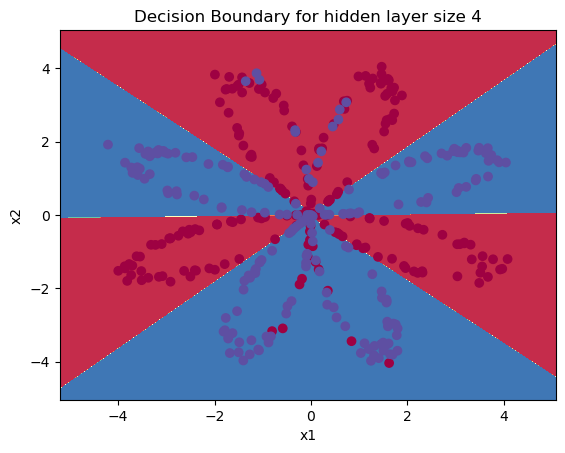

In [160]:
# Build a model with a n_h-dimensional hidden layer
parameters = nn_model(X, Y, n_h = 4, num_iterations = 10000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

**Ожидаемый результат**:

<table style="width:40%">
  <tr>
    <td>**Cost after iteration 9000**</td>
    <td> 0.218607 </td>
  </tr>
  
</table>


In [161]:
# Print accuracy
predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100) + '%')

Accuracy: 90%


**Ожидаемый результат**:

<table style="width:15%">
  <tr>
    <td>**Accuracy**</td>
    <td> 90% </td>
  </tr>
</table>

Точность действительно высока по сравнению с логистической регрессией. Модель выучила узор листьев цветка! Нейронные сети способны изучать даже сильно нелинейные границы принятия решений, в отличие от логистической регрессии.

Теперь давайте попробуем несколько размеров скрытого слоя.

### 4.6 – Настройка размера скрытого слоя ###

Запустите следующий код. Это может занять 1-2 минуты. Вы увидите различное поведение модели для разных размеров скрытых слоев.

Accuracy for 1 hidden units: 67.5 %
Accuracy for 2 hidden units: 67.25 %
Accuracy for 3 hidden units: 90.75 %
Accuracy for 4 hidden units: 90.5 %
Accuracy for 5 hidden units: 91.25 %
Accuracy for 20 hidden units: 90.0 %
Accuracy for 50 hidden units: 90.25 %


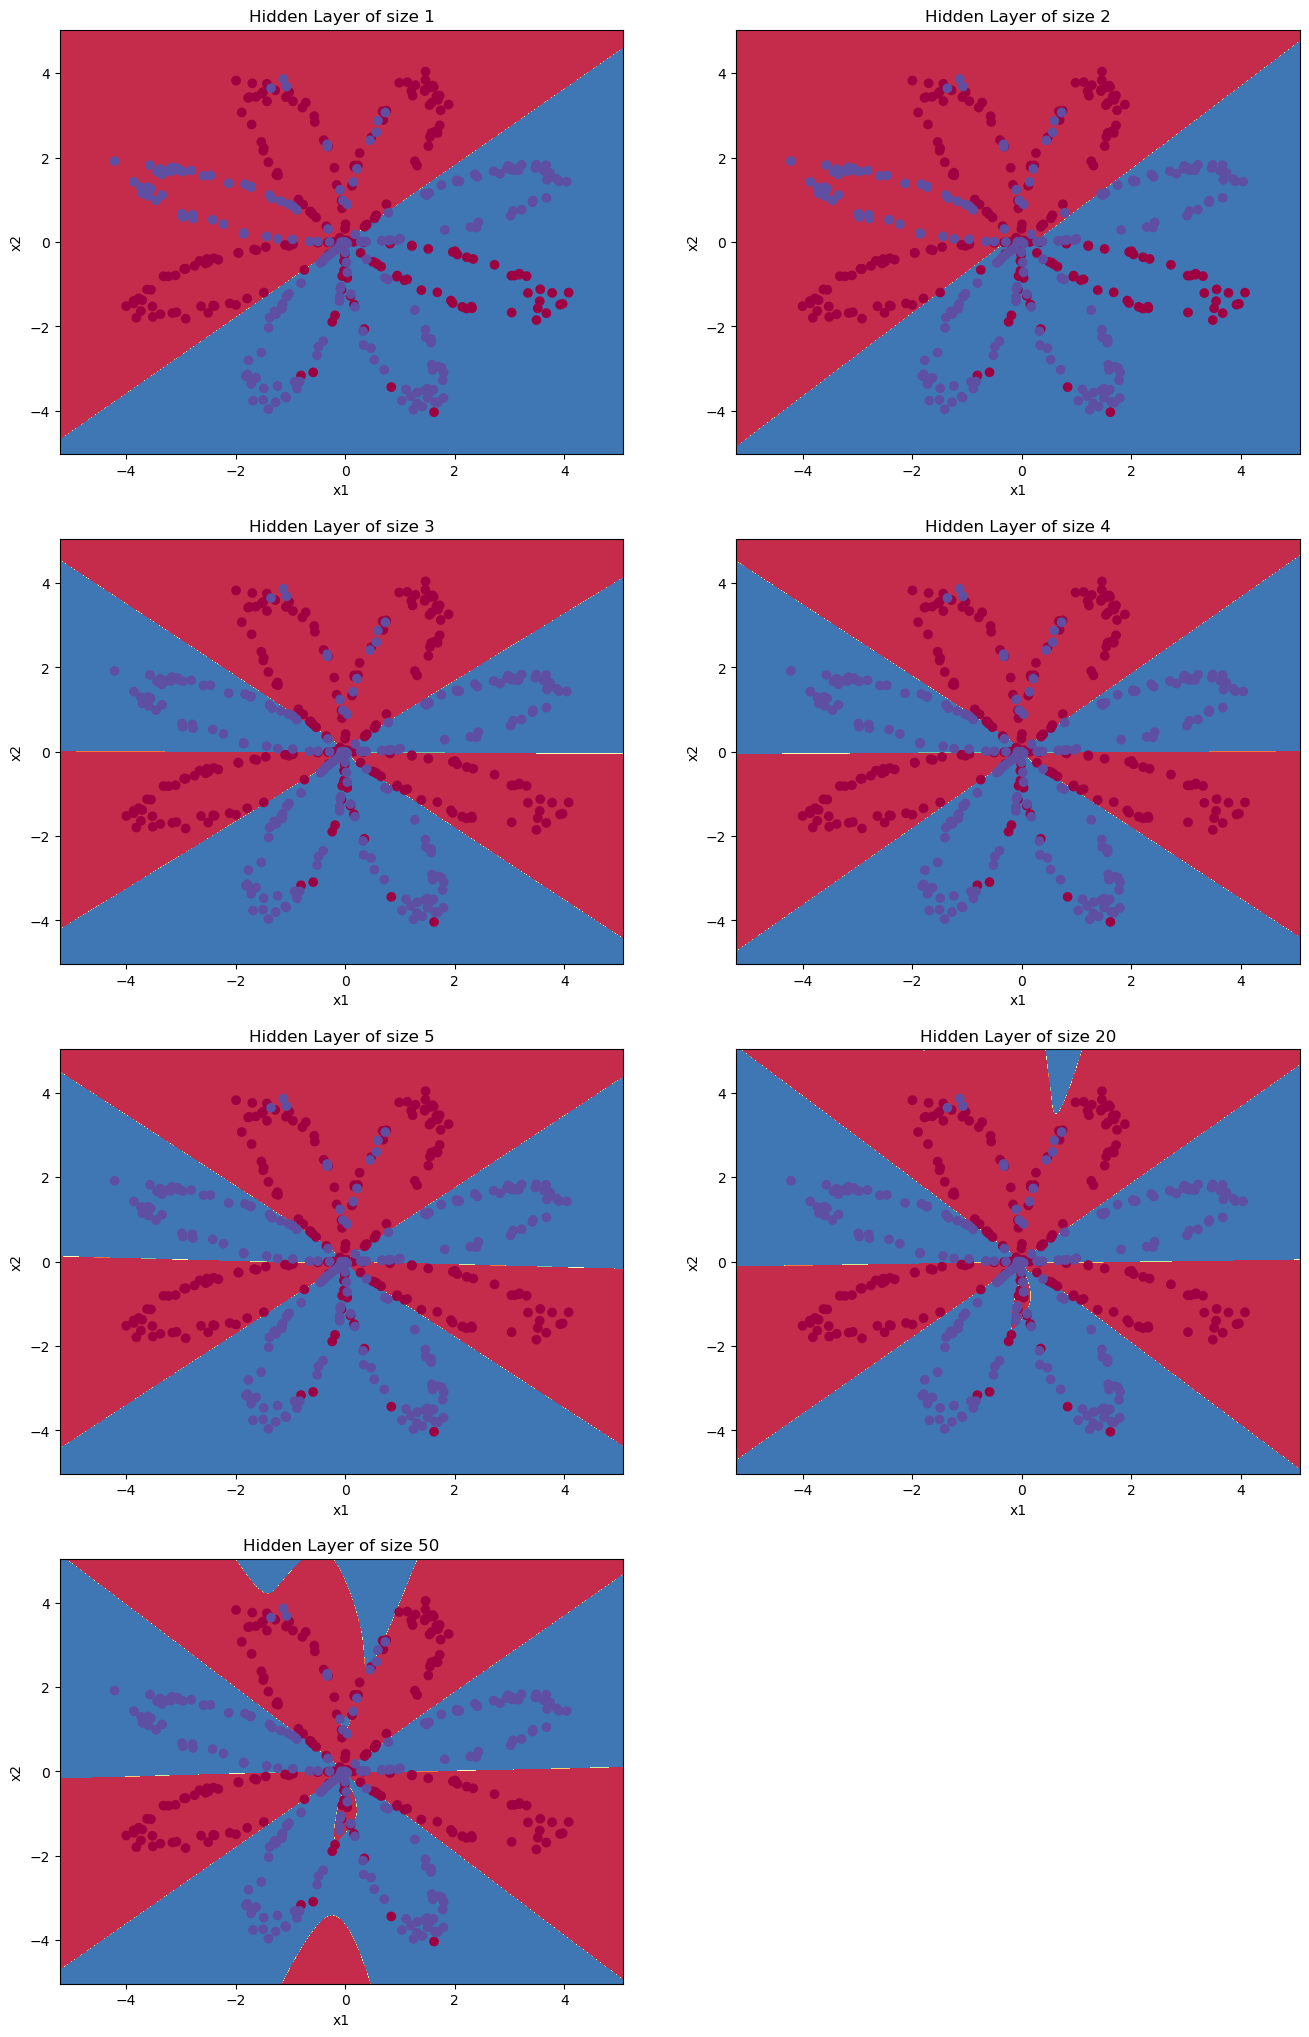

In [52]:
# This may take about 2 minutes to run

plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

**Интерпретация результатов**:  
- Более крупные модели (с большим количеством скрытых нейронов) могут лучше соответствовать обучающему набору, пока в конечном итоге самые большие модели не переобучатся на данных.
- Лучший размер скрытого слоя, по-видимому, составляет около n_h = 5. Действительно, значение здесь, похоже, хорошо соответствует данным, не вызывая при этом заметного переобучения.
- Позже вы также узнаете о регуляризации, которая позволяет использовать очень большие модели (например, n_h = 50) без особого переобучения.

**Дополнительные вопросы**:

**Примечание**.
Некоторые дополнительные/неклассифицированные вопросы, которые вы можете изучить, если хотите:
- Что произойдет, если вы измените активацию `tanh` на активацию сигмовидной кишки или активацию `ReLU`?
- Поиграйте со скоростью обучения. Что происходит?
- Что, если мы изменим набор данных? (См. часть 5 ниже!)

Если изменим tanh на активацию ReLU, для этого в коде нужно использовать np.maximum(0, Z1) вместо np.tanh(Z1).

In [53]:
# GRADED FUNCTION: forward_propagation

def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)

    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    # Извлечение параметров из словаря "parameters"
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    # Реализация прямого распространения
    Z1 = np.dot(W1, X) + b1                     # Вычисление Z1
    A1 = np.maximum(0, Z1)                      # Применение ReLU к Z1
    Z2 = np.dot(W2, A1) + b2                    # Вычисление Z2
    A2 = 1 / (1 + np.exp(-Z2))                  # Применение сигмоиды к Z2

    assert(A2.shape == (1, X.shape[1]))  # Проверка формы A2

    # Сохранение промежуточных значений в кэш
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}

    return A2, cache

In [54]:
X_assess, parameters = forward_propagation_test_case()
A2, cache = forward_propagation(X_assess, parameters)

# Note: we use the mean here just to make sure that your output matches ours.
print(np.mean(cache['Z1']) ,np.mean(cache['A1']),np.mean(cache['Z2']),np.mean(cache['A2']))

0.26281864019752443 0.5169481739557227 -1.316674923043789 0.21137203181362854


In [61]:
# Print accuracy
predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100) + '%')

Accuracy: 50%


Прошлый результат с tanh
0.26281864019752443 0.09199904522700109 -1.3076660128732143 0.21287768171914198

точность: 90%

**Поиграем со скоростью обучения**

Изменяем скорость градиентного спуска в параменте learning_rate

При 10000:

In [141]:
# Print accuracy
predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100) + '%')

Accuracy: 51%


/var/folders/hy/7pskr2nx7bz2l6b8k96ptwnh0000gn/T/ipykernel_85857/2650695675.py:26: RuntimeWarning: overflow encountered in exp
  A2 = 1 / (1 + np.exp(-Z2))                  # Применение сигмоиды к Z2


При 10:

In [148]:
# Print accuracy
predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100) + '%')

Accuracy: 90%


При 0.1:

In [155]:
# Print accuracy
predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100) + '%')

Accuracy: 89%


## **Вы научились:**  
- Строить полную нейронную сеть со скрытым слоем.  
- Правильно использовать нелинейные функции.  
- Реализовывать прямое и обратное распространение ошибки и обучать нейронную сеть.  
- Наблюдать, как влияет изменение размера скрытого слоя, включая переобучение.

Отличная работа!

## 5) Производительность на других наборах данных

Попробуйте повторно запустить весь блокнот (за исключением части набора данных) для каждого из следующих наборов данных.

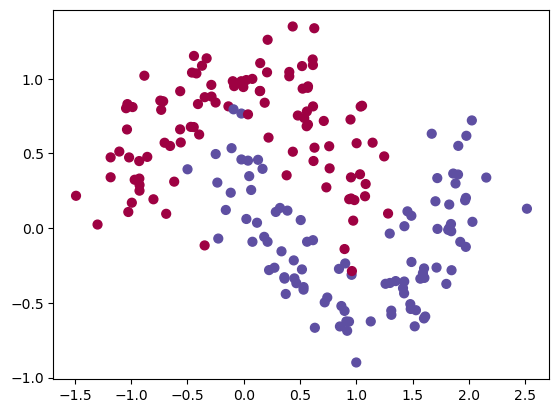

In [34]:
# Datasets
noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets()

datasets = {"noisy_circles": noisy_circles,
            "noisy_moons": noisy_moons,
            "blobs": blobs,
            "gaussian_quantiles": gaussian_quantiles}

### START CODE HERE ### (choose your dataset)
dataset = "gaussian_quantiles"
### END CODE HERE ###

X, Y = datasets[dataset]
X, Y = X.T, Y.reshape(1, Y.shape[0])

# make blobs binary
if dataset == "blobs":
    Y = Y%2

# Visualize the data
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);

Поздравляем с завершением этого задания по программированию!

Ссылки:
- https://adamharley.com/nn_vis/cnn/2d.html
- http://cs231n.github.io/neural-networks-case-study/

Cost after iteration 0: 0.692994
Cost after iteration 1000: 0.316107
Cost after iteration 2000: 0.065964
Cost after iteration 3000: 0.052054
Cost after iteration 4000: 0.045031
Cost after iteration 5000: 0.040755
Cost after iteration 6000: 0.037782
Cost after iteration 7000: 0.035498
Cost after iteration 8000: 0.033630
Cost after iteration 9000: 0.032046


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

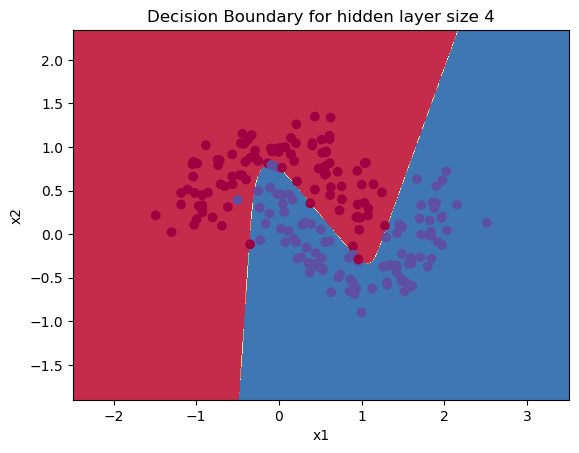

In [59]:
# Build a model with a n_h-dimensional hidden layer
parameters = nn_model(X, Y, n_h = 4, num_iterations = 10000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

Accuracy for 1 hidden units: 86.0 %
Accuracy for 2 hidden units: 87.5 %
Accuracy for 3 hidden units: 98.5 %
Accuracy for 4 hidden units: 98.5 %
Accuracy for 5 hidden units: 99.5 %
Accuracy for 20 hidden units: 86.0 %
Accuracy for 50 hidden units: 85.5 %


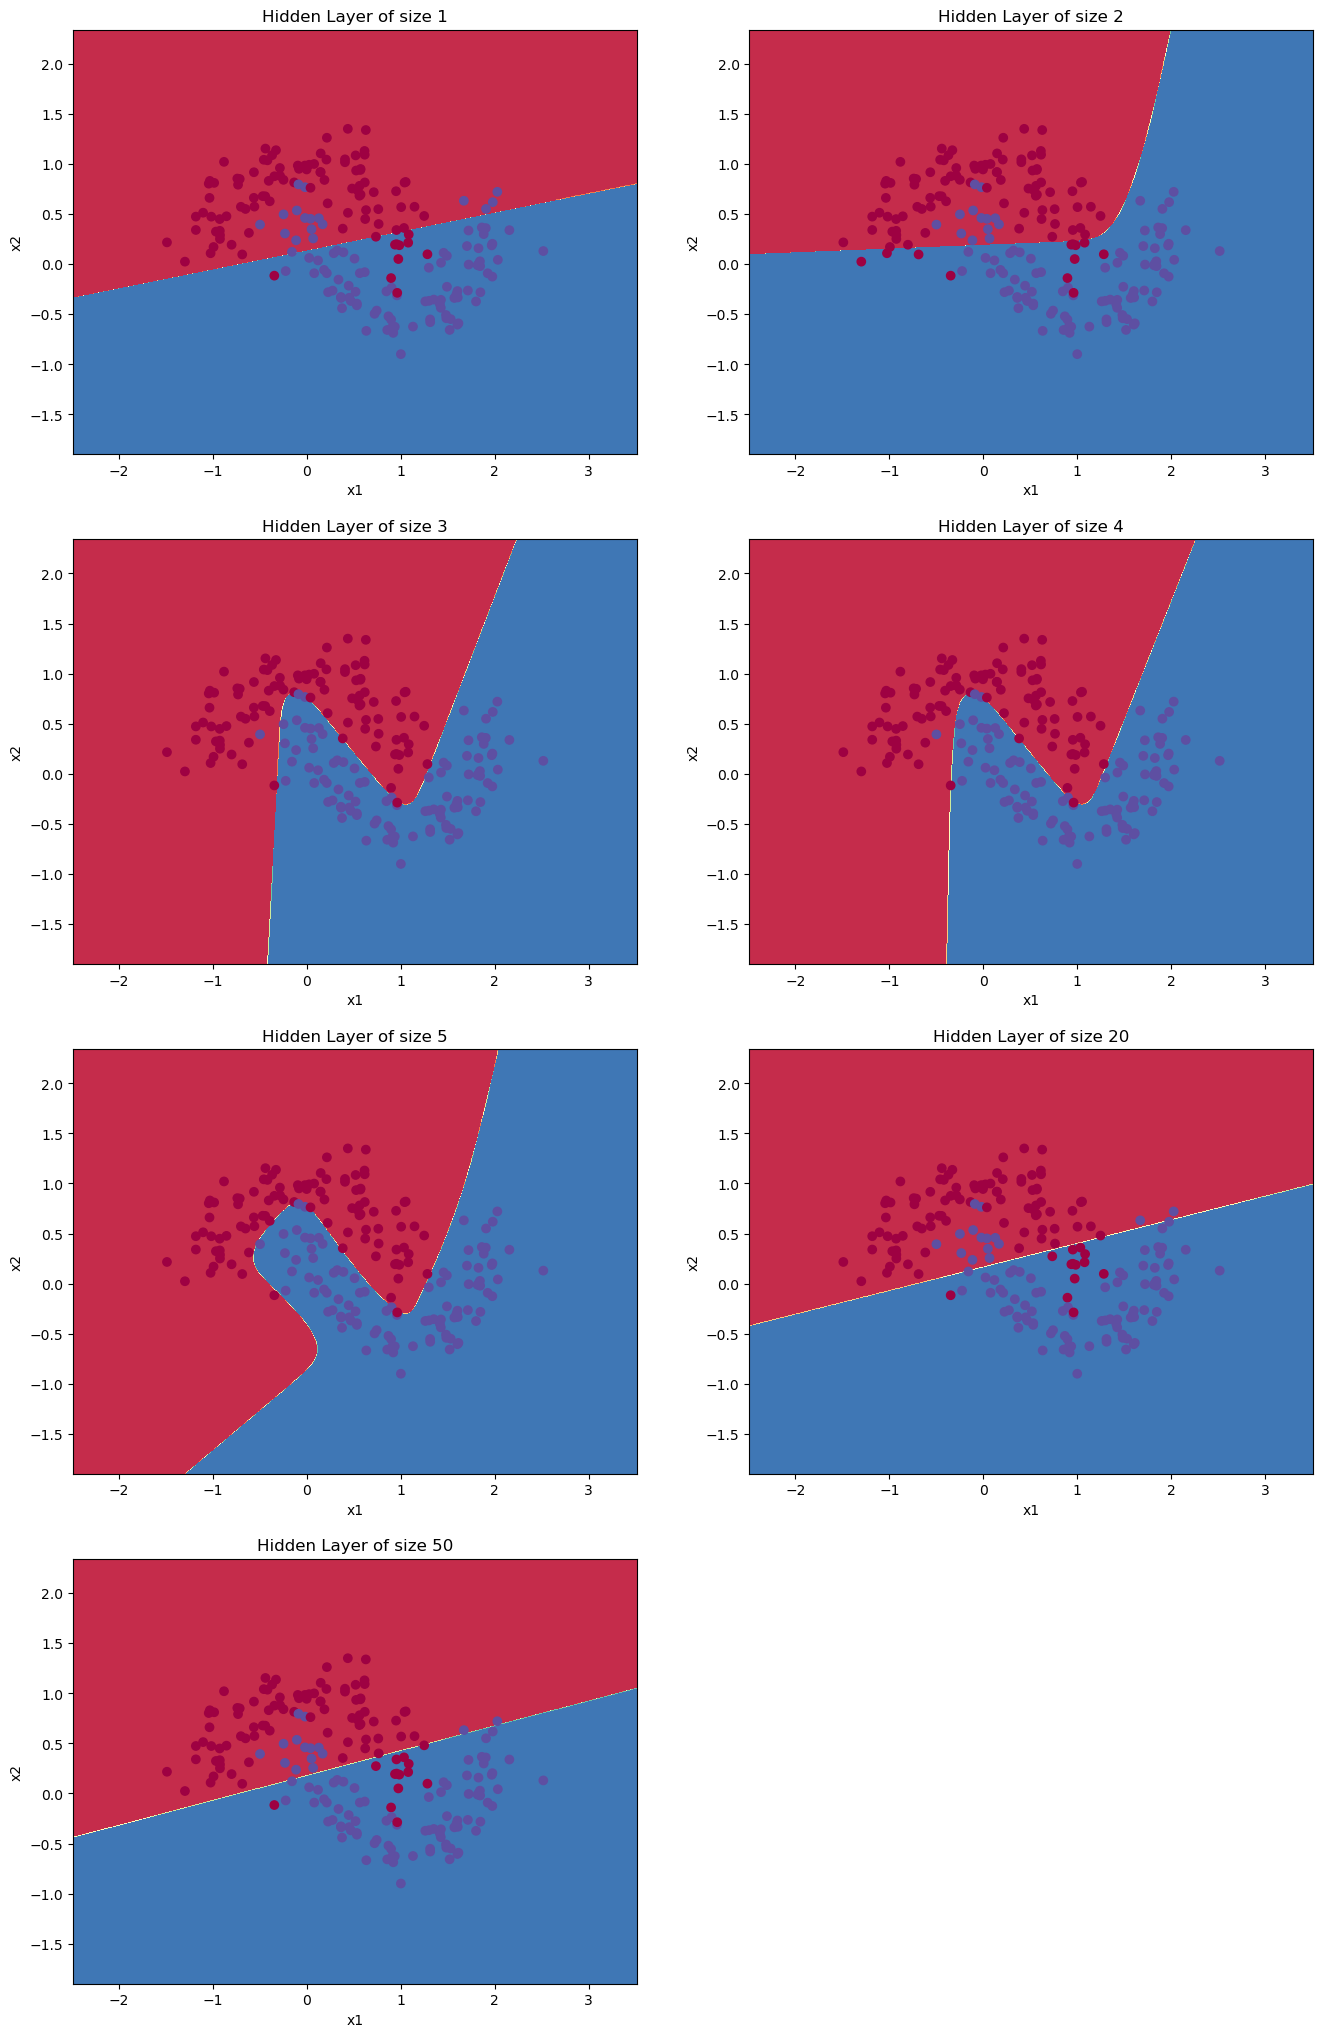

In [60]:
# This may take about 2 minutes to run

plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

Cost after iteration 0: 0.693151
Cost after iteration 1000: 0.438648
Cost after iteration 2000: 0.443356
Cost after iteration 3000: 0.443361
Cost after iteration 4000: 0.443206
Cost after iteration 5000: 0.443017
Cost after iteration 6000: 0.442821
Cost after iteration 7000: 0.442629
Cost after iteration 8000: 0.442447
Cost after iteration 9000: 0.442274


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

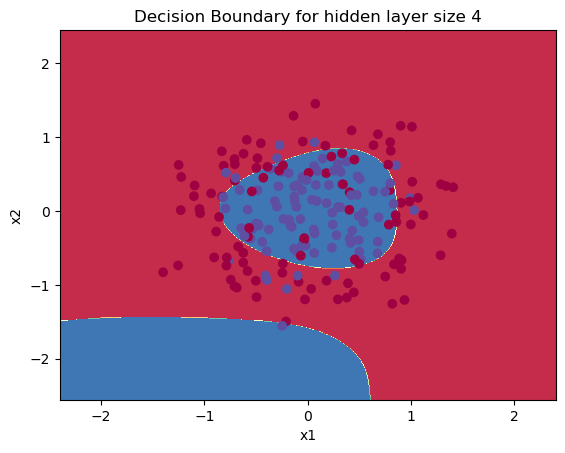

In [84]:
# Build a model with a n_h-dimensional hidden layer
parameters = nn_model(X, Y, n_h = 4, num_iterations = 10000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

Accuracy for 1 hidden units: 60.0 %
Accuracy for 2 hidden units: 71.0 %
Accuracy for 3 hidden units: 79.5 %
Accuracy for 4 hidden units: 81.0 %
Accuracy for 5 hidden units: 80.0 %
Accuracy for 20 hidden units: 80.0 %
Accuracy for 50 hidden units: 81.0 %


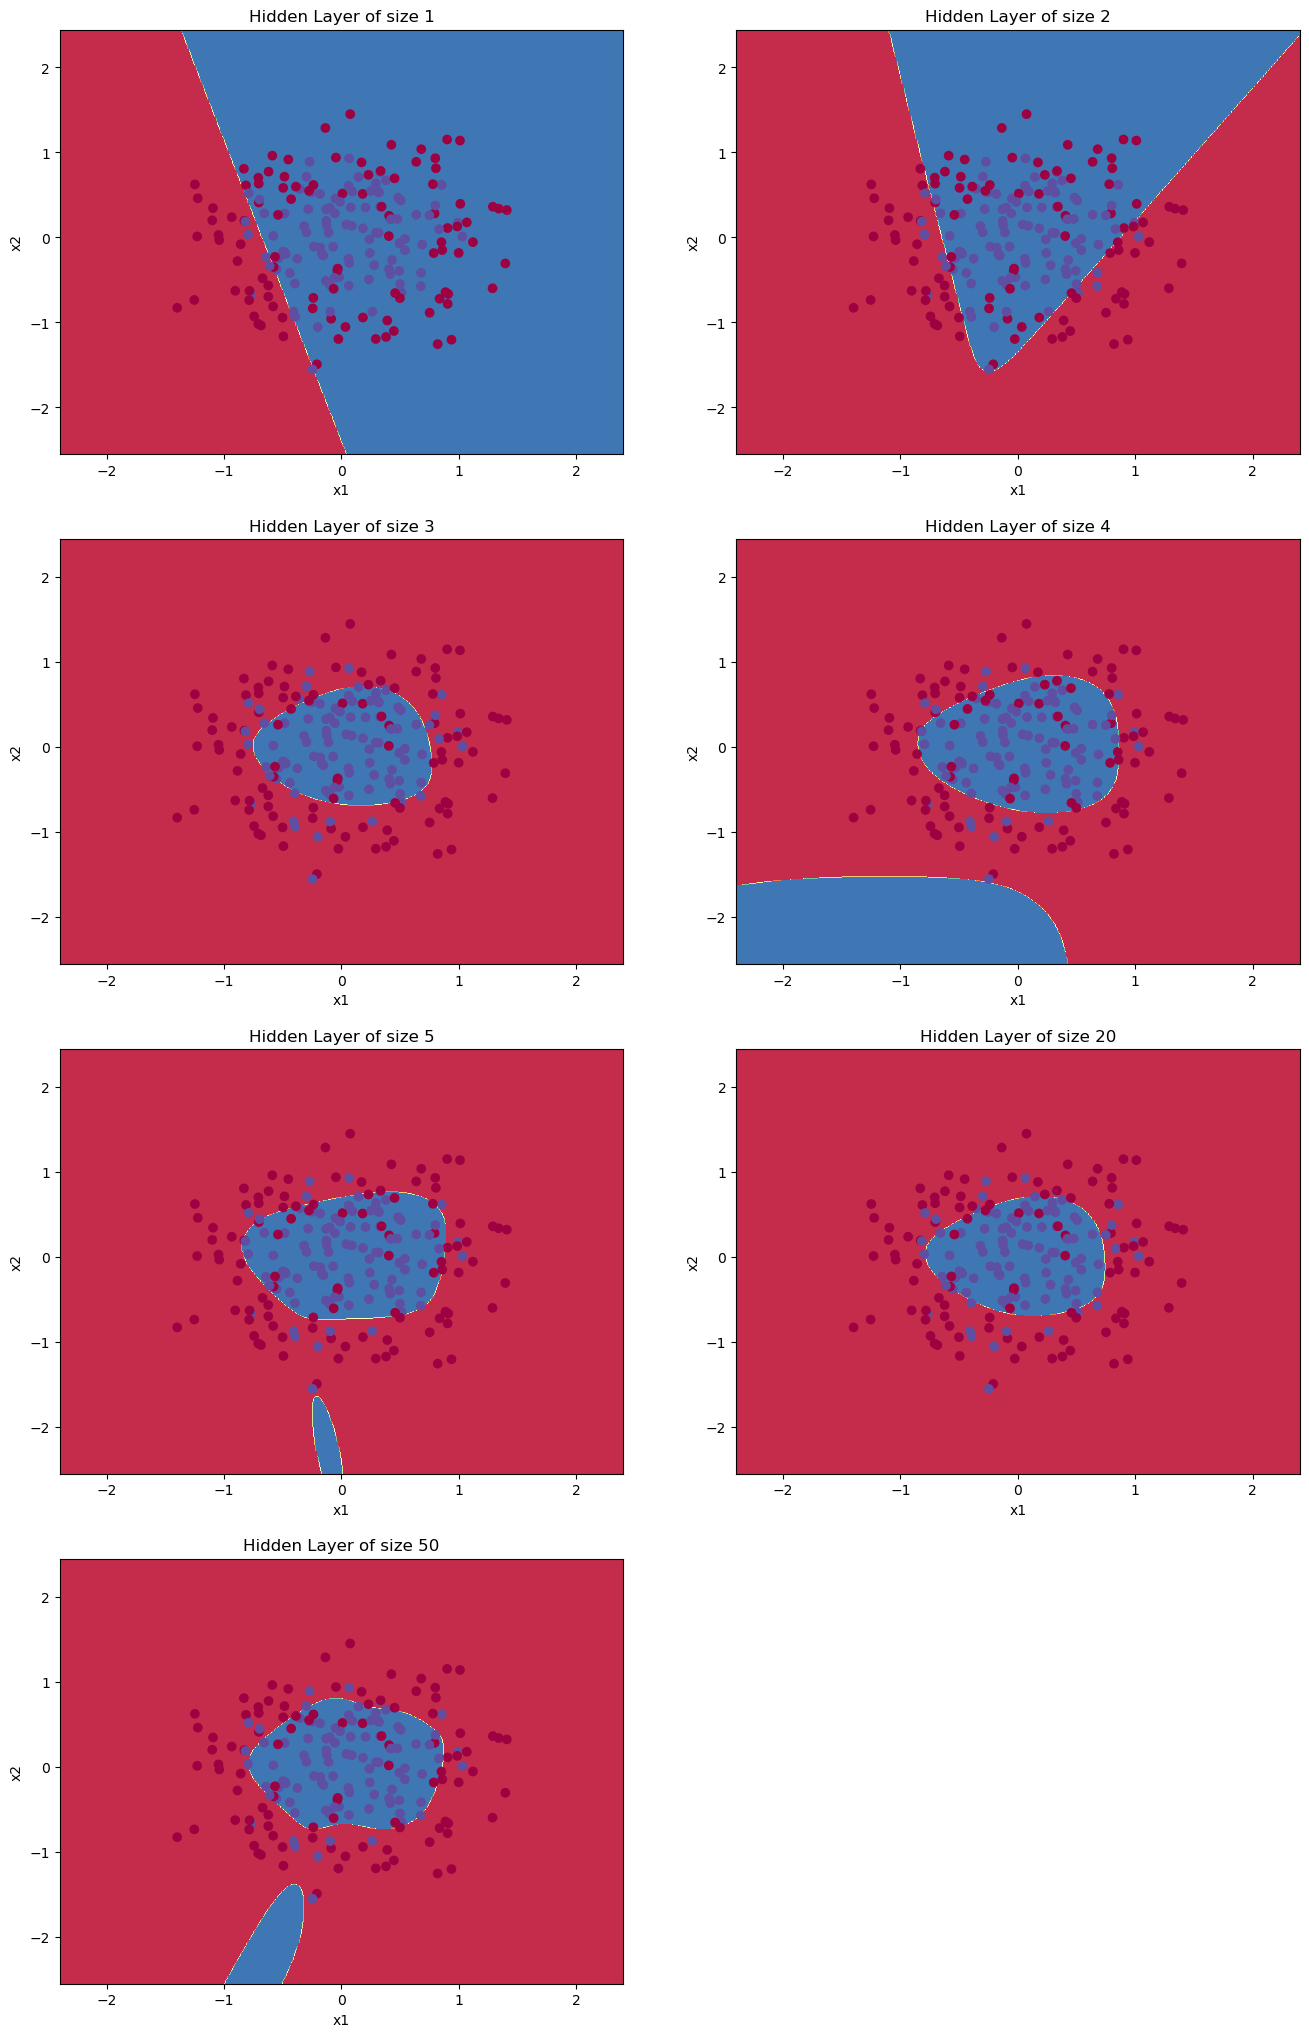

In [85]:
# This may take about 2 minutes to run

plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

Cost after iteration 0: 0.693527
Cost after iteration 1000: 0.324252
Cost after iteration 2000: 0.323291
Cost after iteration 3000: 0.323034
Cost after iteration 4000: 0.322913
Cost after iteration 5000: 0.322843
Cost after iteration 6000: 0.322797
Cost after iteration 7000: 0.322765
Cost after iteration 8000: 0.322741
Cost after iteration 9000: 0.322722


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

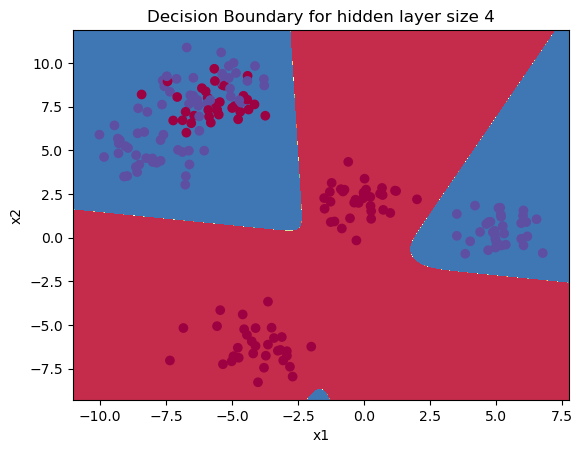

In [134]:
# Build a model with a n_h-dimensional hidden layer
parameters = nn_model(X, Y, n_h = 4, num_iterations = 10000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

Accuracy for 1 hidden units: 67.0 %
Accuracy for 2 hidden units: 67.0 %
Accuracy for 3 hidden units: 83.0 %
Accuracy for 4 hidden units: 83.0 %
Accuracy for 5 hidden units: 83.0 %
Accuracy for 20 hidden units: 87.0 %
Accuracy for 50 hidden units: 83.5 %


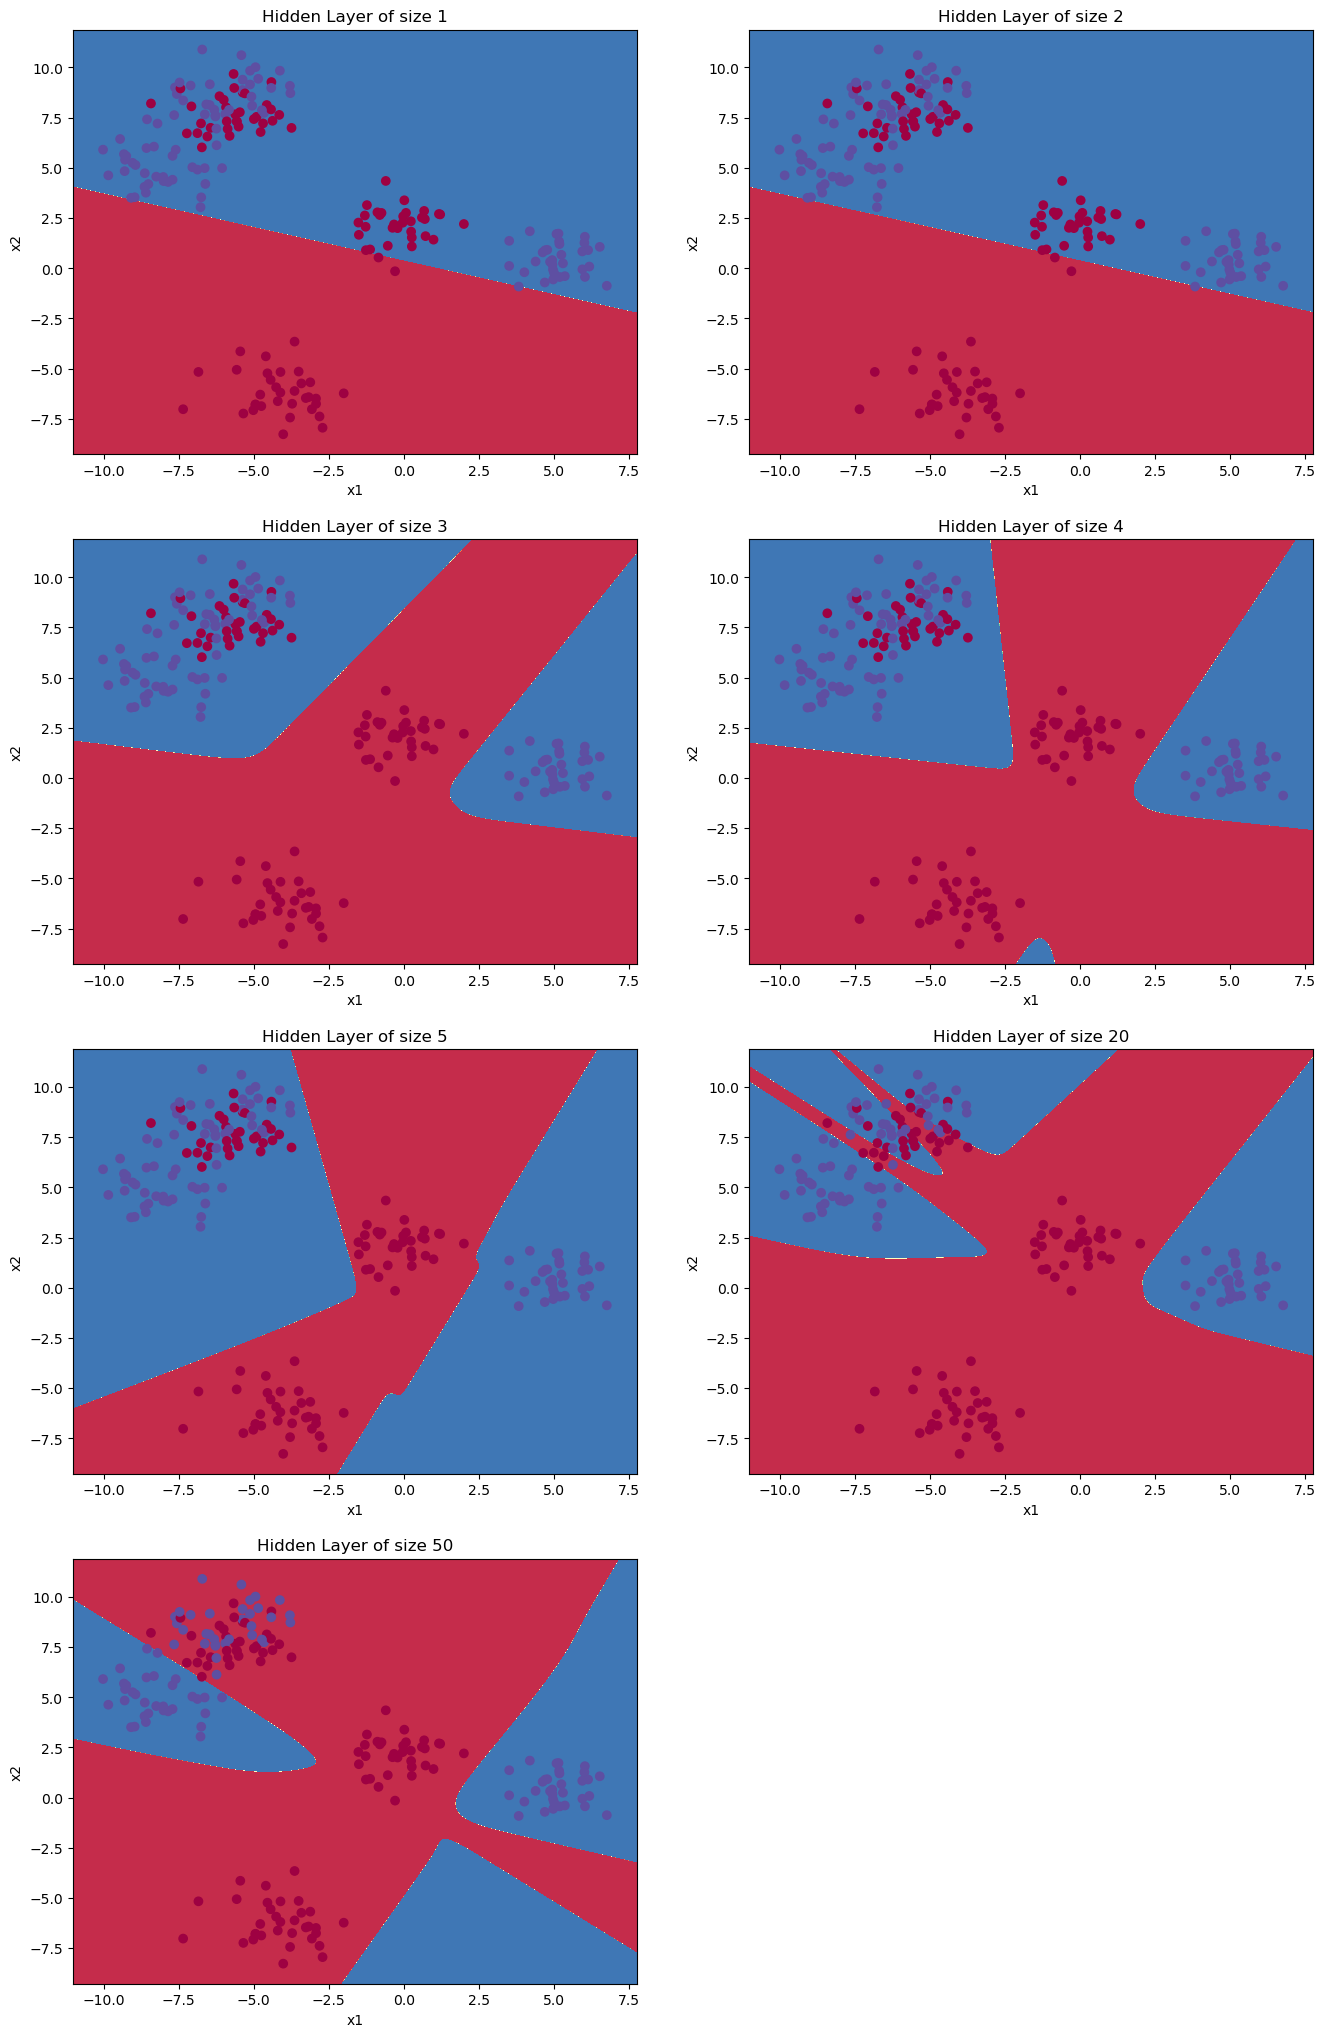

In [135]:
# This may take about 2 minutes to run

plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

Cost after iteration 0: 0.693148
Cost after iteration 1000: 0.099171
Cost after iteration 2000: 0.101850
Cost after iteration 3000: 0.067505
Cost after iteration 4000: 0.075971
Cost after iteration 5000: 0.072494
Cost after iteration 6000: 0.069946
Cost after iteration 7000: 0.069321
Cost after iteration 8000: 0.063546
Cost after iteration 9000: 0.067826


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

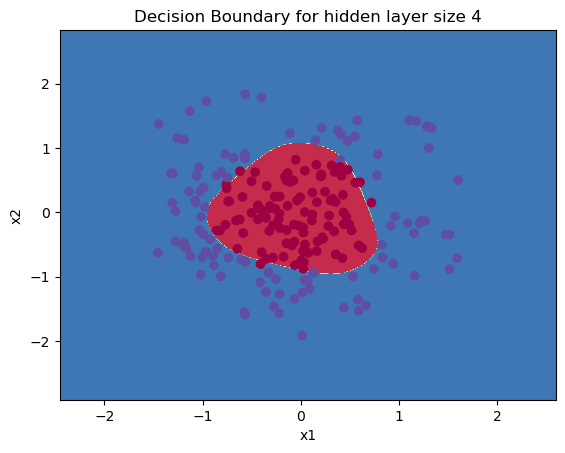

In [158]:
# Build a model with a n_h-dimensional hidden layer
parameters = nn_model(X, Y, n_h = 4, num_iterations = 10000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

Accuracy for 1 hidden units: 66.5 %
Accuracy for 2 hidden units: 80.0 %
Accuracy for 3 hidden units: 95.0 %
Accuracy for 4 hidden units: 97.0 %
Accuracy for 5 hidden units: 96.5 %
Accuracy for 20 hidden units: 100.0 %
Accuracy for 50 hidden units: 97.0 %


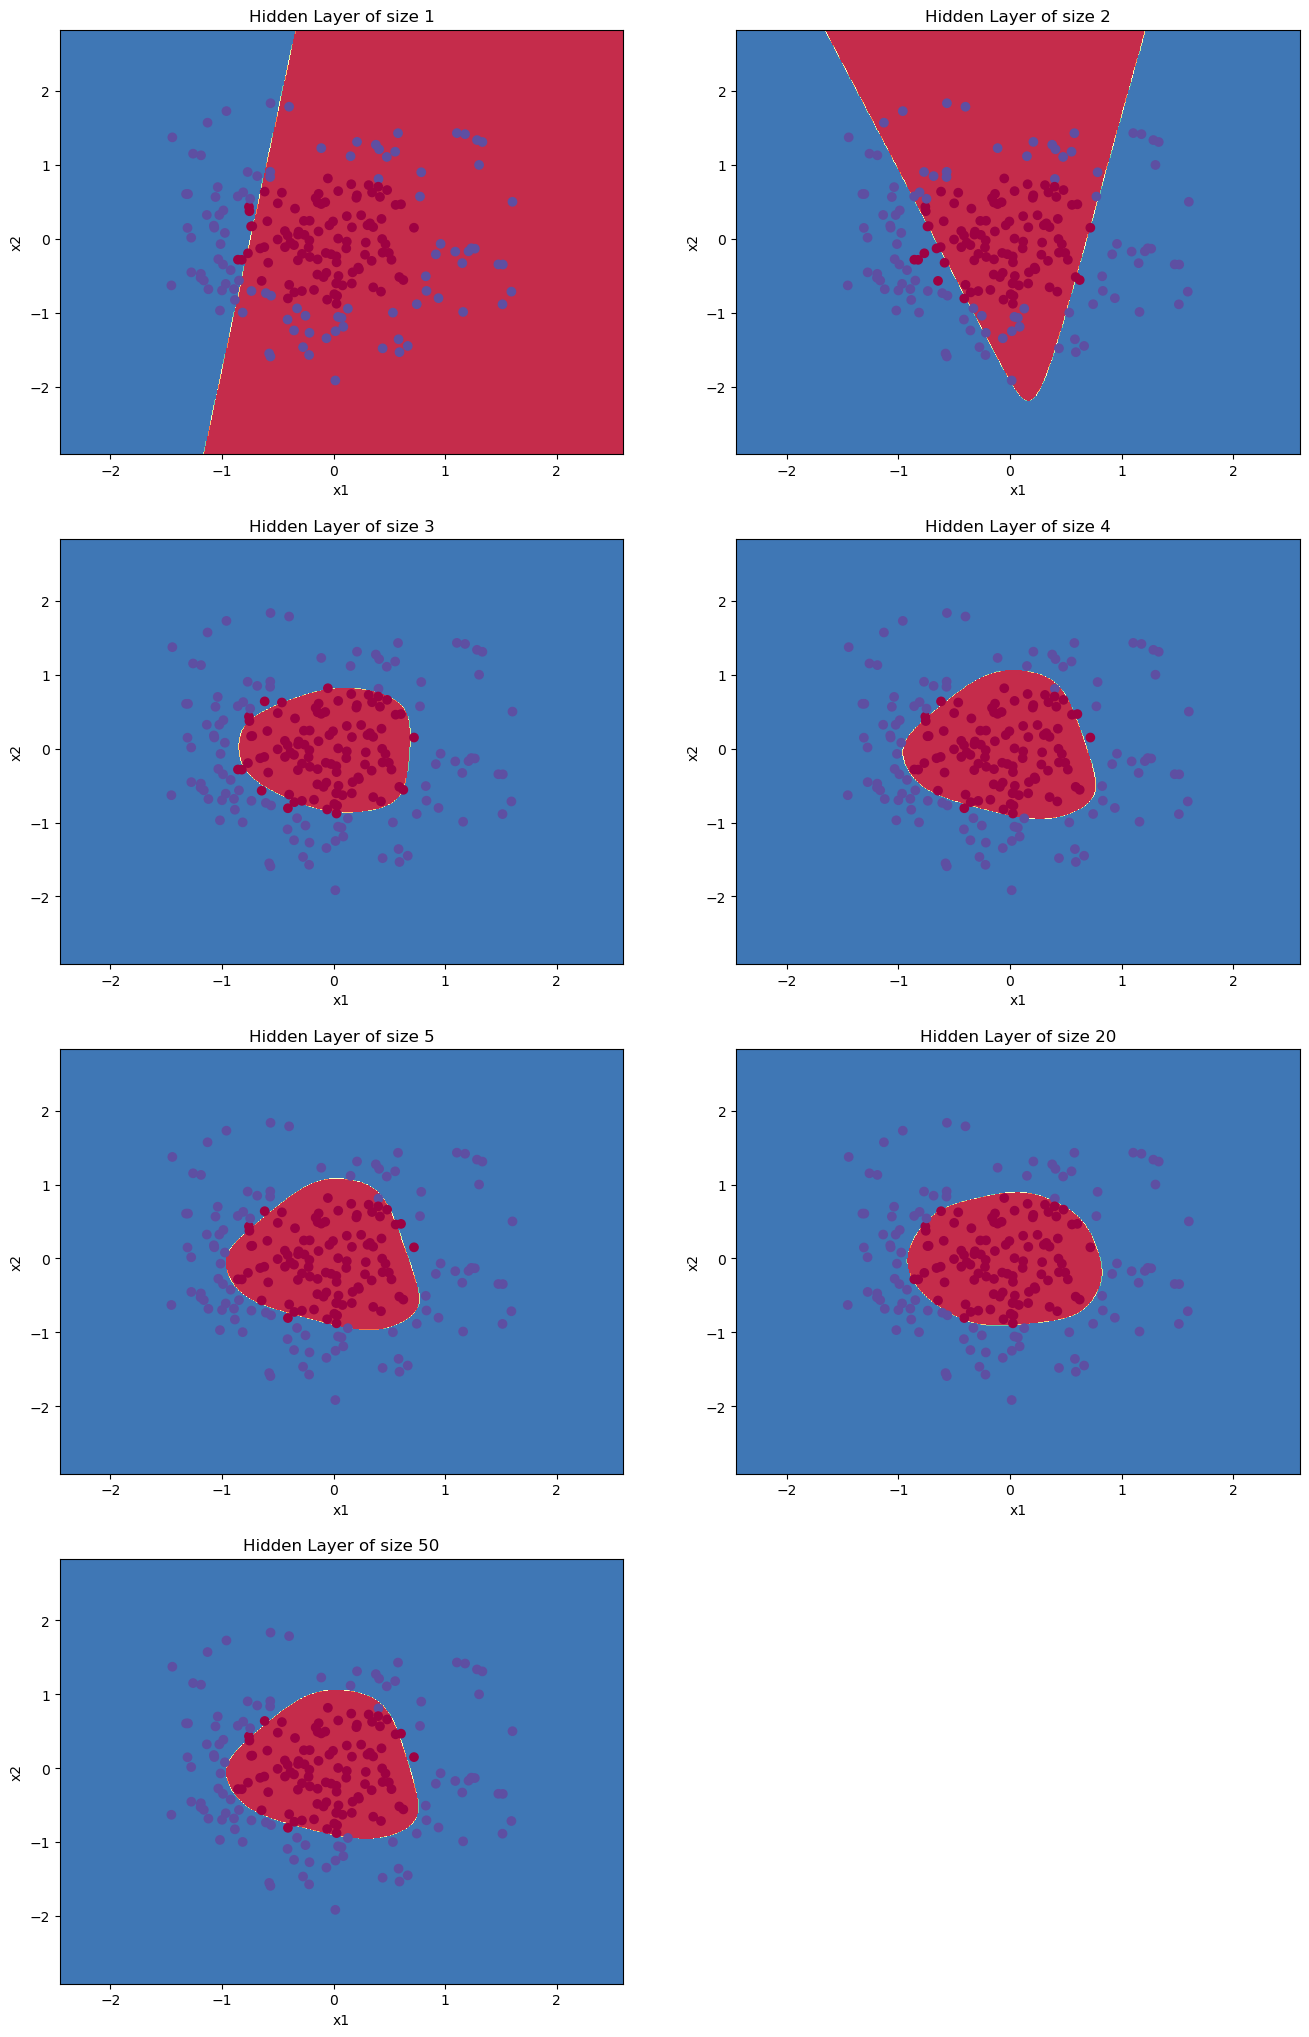

In [159]:
# This may take about 2 minutes to run

plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))